# Solution tRAT 4

---
---

**Author:** Dr Giordano Scarciotti (g.scarciotti@imperial.ac.uk) - Imperial College London

**Module:** ELEC70066 - Applied Advanced Optimisation

**Version:** 1.1.3 - 06/02/2025

---
---

# IMPORTANT: read this

This test has a long explanation, but the coding part is very brief. Make sure you understand the text.

It turns out that CVXPY usually is not able to solve quasiconvex optimisation problems in the way you have just done, because CVXPY does not always recognise the transformed feasibility problem as convex (i.e. even if you prove its sublevel sets are convex, CVXPY may not know this and thinks that the problem is not convex).

The reason the problem that you have just solved worked is because for that special case the transformed problem is just an LP, which CVXPY recognises as convex.

Despite this, CVXPY can solve some quasiconvex optimisation problems directly, by using a specially designed quasiconvex solver, on specially designed quasiconvex atoms. This solver does nothing else than using the bisection algorithm, but it is capable of recognising some classes of quasiconvex problems. For instance consider the problem

$$
\begin{array}{ll}
\displaystyle \max_{x} &  \displaystyle \frac{\sqrt{x}}{e^x}
\end{array} \tag{1}
$$

This is a quasiconvex problem because $\frac{\sqrt{x}}{e^x}$ is a quasiconcave function, as the graph below shows.

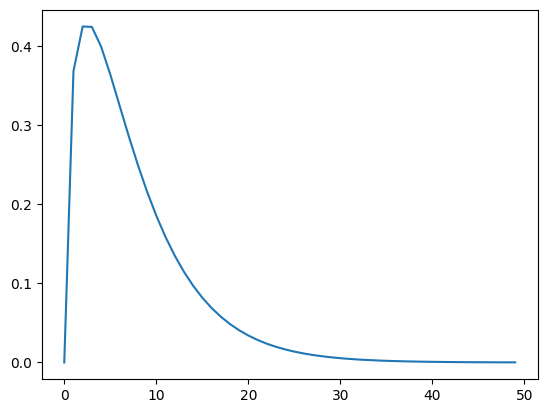

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.plot([np.sqrt(y) / np.exp(y) for y in np.linspace(0, 10)])
plt.show()

Problem $(1)$ can be solved easily using the following code:

In [ ]:
x = cp.Variable()
problem = cp.Problem(cp.Maximize(cp.sqrt(x) / cp.exp(x)))
problem.solve(qcp=True, solver='SCS') # We need to tell cvxpy that this is quasiconvex
# and we need to pick a solver different from the default.

0.4288819413276109

Note that in the code above we simply declared the objective function as we would normally do for a convex problem and we solved it with the command `problem.solve(qcp=True)`. This command is important because it tells CVXPY to use the quasiconvex solver.

For the sake of clarity, note that this problem can be solved using bisection (like you did before) on a feasibility problem, but for more general problems (like the ones in the exercises below) CVXPY does not recognize that the feasibility problem is convex and you must use the quasiconvex solver.

In [ ]:
# Tolerance, upper and lower bound for the bisection
u = 0
l = -10
tol = 0.0001

# Bisection algorithm
while u-l >= tol:
  gamma = (l+u)/2
  # Formulation and soluton of the feasibility problem
  constr = [-cp.sqrt(x)<=gamma*cp.exp(x),x>=0]
  prob = cp.Problem(cp.Minimize(0),constr)
  prob.solve(solver='SCS')

  if prob.status == 'optimal':
    u=gamma
    x_opt=x.value
    objval_opt=gamma
  else:
    l=gamma

print(-objval_opt)

0.427703857421875


# Exercise 1

Consider the problem of minimising the ratio of the Eucliden distance from $a$ over the Eucliden distance from $b$, namely

$$
\min \quad \frac{||x-a||_2}{||x-b||_2}
$$

This is a quasiconvex optimisation problem.

*   Solve it with the data given below. Note that you need to use the [quasiconvex atom](https://www.cvxpy.org/tutorial/dqcp/index.html?highlight=dist_ratio#dqcp-atoms) `cvxpy.dist_ratio(x, a, b)` which denotes the function $\frac{||x-a||_2}{||x-b||_2}$.
*   Print the optimal ratio.
*   Print the optimal $x$.

In [ ]:
# Data
n = 10
np.random.seed(1)
a = np.random.randn(n)
b = np.random.randn(n)

# Exercise 2

Consider the problem of finding the *minimum-length* least squares approximation of a vector $b$. The length of a vector in $\mathbb{R}^n$ is defined as the largest index corresponding to a nonzero component:

$$
\text{len}(x) = \max\{i : x_i \ne 0\}.
$$

This function is quasiconvex on $\mathbb{R}^n$ because its sublevel sets are subspaces and it is implemented in CVXPY by the atom `cvxpy.length(x)`. The problem can be formulated as

$$
\begin{array}{ll}
\displaystyle \min_{x} &  \text{len} (x) \\
\text{s.t. } & \frac{1}{n}||Ax-b||_2^2 \le \varepsilon.
\end{array}
$$

where $\frac{1}{n}||Ax-b||_2^2$ is the Mean-Square Error (MSE).

The data of the problem is


In [ ]:
# Data
n = 10
np.random.seed(1)
A = np.random.randn(n, n)
b = A @ np.random.randn(n)
epsilon = 1e-2



*   Solve the problem and print the optimal length
*   Print the optimal MSE
*   Print the optimal $x$ rounded to two decimal digits



# Solution

## Exercise 1

In [ ]:
n = 10
np.random.seed(1)
a = np.random.randn(n)
b = np.random.randn(n)

In [ ]:
x = cp.Variable(n)

problem = cp.Problem(cp.Minimize(cp.dist_ratio(x,a,b)), [])
print("Is problem DQCP?: ", problem.is_dqcp())

problem.solve(qcp=True, solver='SCS')
print("The optimal ratio is: ", problem.value)

Is problem DQCP?:  True
The optimal ratio is:  0.22221760907697272


In [ ]:
x.value

array([ 1.33063006, -0.07722087, -0.47563611, -1.04232958,  0.60928476,
       -2.15827203,  1.91879686, -0.5694541 ,  0.33014413, -0.43099217])

Note that using directly bisection does not work on this problem.

In [ ]:
# Tolerance, upper and lower bound for the bisection
x = cp.Variable(n)
u = 1
l = 0
tol = 0.001

# Bisection algorithm
while u-l >= tol:
  gamma = (l+u)/2
  # Formulation and soluton of the feasibility problem
  constr = [cp.norm(x-a)<=gamma*cp.norm(x-b)]
  #constr = [(1-gamma*gamma)*x.T*x - 2*x.T*(a-gamma*gamma*b) + a.T*a-gamma*gamma*b.T*b<=0]
  prob = cp.Problem(cp.Minimize(0),constr)
  prob.solve(solver='SCS')

  if prob.status == 'optimal':
    u=gamma
    x_opt=x.value
    objval_opt=gamma
  else:
    l=gamma

print(objval_opt)
print(x_opt)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
Pnorm(var14159 + -[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038], 2) <= 0.5 @ Pnorm(var14159 + -[ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944 -1.09989127
 -0.17242821 -0.87785842  0.04221375  0.58281521], 2) , because the following subexpressions are not:
|--  Pnorm(var14159 + -[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038], 2) <= 0.5 @ Pnorm(var14159 + -[ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944 -1.09989127
 -0.17242821 -0.87785842  0.04221375  0.58281521], 2)

## Exercise 2

In [ ]:
n = 10
np.random.seed(1)
A = np.random.randn(n, n)
b = A @ np.random.randn(n)
epsilon = 1e-2

In [ ]:
x = cp.Variable(n)
mse = cp.sum_squares(A @ x - b)/n
problem = cp.Problem(cp.Minimize(cp.length(x)), [mse <= epsilon])
print("Is problem DQCP?: ", problem.is_dqcp())

problem.solve(qcp=True,solver='SCS')
print("Found a solution, with length: ", problem.value)
print("MSE: ", mse.value)
print("x: ", np.round(x.value,2))

Is problem DQCP?:  True
Found a solution, with length:  8.0
MSE:  0.00926009354495749
x:  [-0.26  1.38  0.21  0.94 -1.15  0.15  0.66 -1.16 -0.    0.  ]
